In [1]:
import sklearn.cluster as cl
import sklearn.mixture as mi
from sklearn.model_selection import train_test_split

from sklearn.metrics import silhouette_score
import pandas as pd
import time

In [2]:
import numpy as np
import random
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
%matplotlib inline

# Data inladen

De eerste stap is het inladen van de data die identiek is aan die van het Erasmus

In [3]:
df = pd.read_csv("DES.csv")
df

,Unnamed: 0,patient_id,geslacht,geboortedatum,opname_nummer,zkh_opn_start,herkomst,marital_status,race,diagnose,icd_version,start_operatie,endtime,duur_ok_minutes,length_of_stay_days,department,time_to_surgery_minutes,target
0,0,10000032,F,2180-09-09,22595853,2180-05-06 22:23:00,Other,WIDOWED,WHITE,07070,9,2180-05-06 19:17:00,2180-05-07 17:21:27,1324.450000,0.786111,MED,-186.0,0
1,1,10000032,F,2180-09-09,22841357,2180-06-26 18:27:00,Medicaid,WIDOWED,WHITE,07071,9,2180-06-26 15:54:00,2180-06-27 18:49:12,1615.200000,1.015278,MED,-153.0,0
2,2,10000032,F,2180-09-09,25742920,2180-08-05 23:44:00,Medicaid,WIDOWED,WHITE,07054,9,2180-08-05 20:58:00,2180-08-07 17:50:44,2692.733333,1.754167,MED,-166.0,0
3,3,10000068,F,NaN,25022803,2160-03-03 23:16:00,Other,SINGLE,WHITE,30500,9,2160-03-03 21:55:00,2160-03-04 07:33:47,578.783333,0.298611,MED,-81.0,0
4,4,10000117,F,NaN,27988844,2183-09-18 18:10:00,Other,DIVORCED,WHITE,E7800,10,2183-09-18 08:41:00,2183-09-21 16:30:30,4789.500000,2.930556,ORTHO,-569.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229416,229416,19999828,F,NaN,25744818,2149-01-08 16:44:00,Other,SINGLE,WHITE,B954,10,2149-01-08 09:11:00,2149-01-18 18:44:40,14973.666667,10.011111,MED,-453.0,1
229417,229417,19999828,F,NaN,29734428,2147-07-18 16:23:00,Other,SINGLE,WHITE,B9620,10,2147-07-17 17:18:00,2147-08-04 18:12:35,25974.583333,17.074306,SURG,-1385.0,1
229418,229418,19999840,M,2164-09-17,21033226,2164-09-10 13:47:00,Other,WIDOWED,WHITE,2724,9,2164-09-10 11:09:00,2164-09-17 16:35:15,10406.250000,6.996528,MED,-158.0,1
229419,229419,19999840,M,2164-09-17,26071774,2164-07-25 00:27:00,Other,WIDOWED,WHITE,2724,9,2164-07-24 21:16:00,2164-07-28 12:22:30,5226.500000,3.491667,NMED,-191.0,1


# Modellen Zoeken

We zoeken naar een clusteringsmodel wat gelijke patienten kan voorspellen. Met behulp van Sklearn en de visualisatie van hun modellen zijn de modellen gekozen:

Kmeans, Affinity Propagation, Spectral clustering, Agglomorative Clustering, DBSCAN, OPTICS, BIRCH en Gaussian Mixture

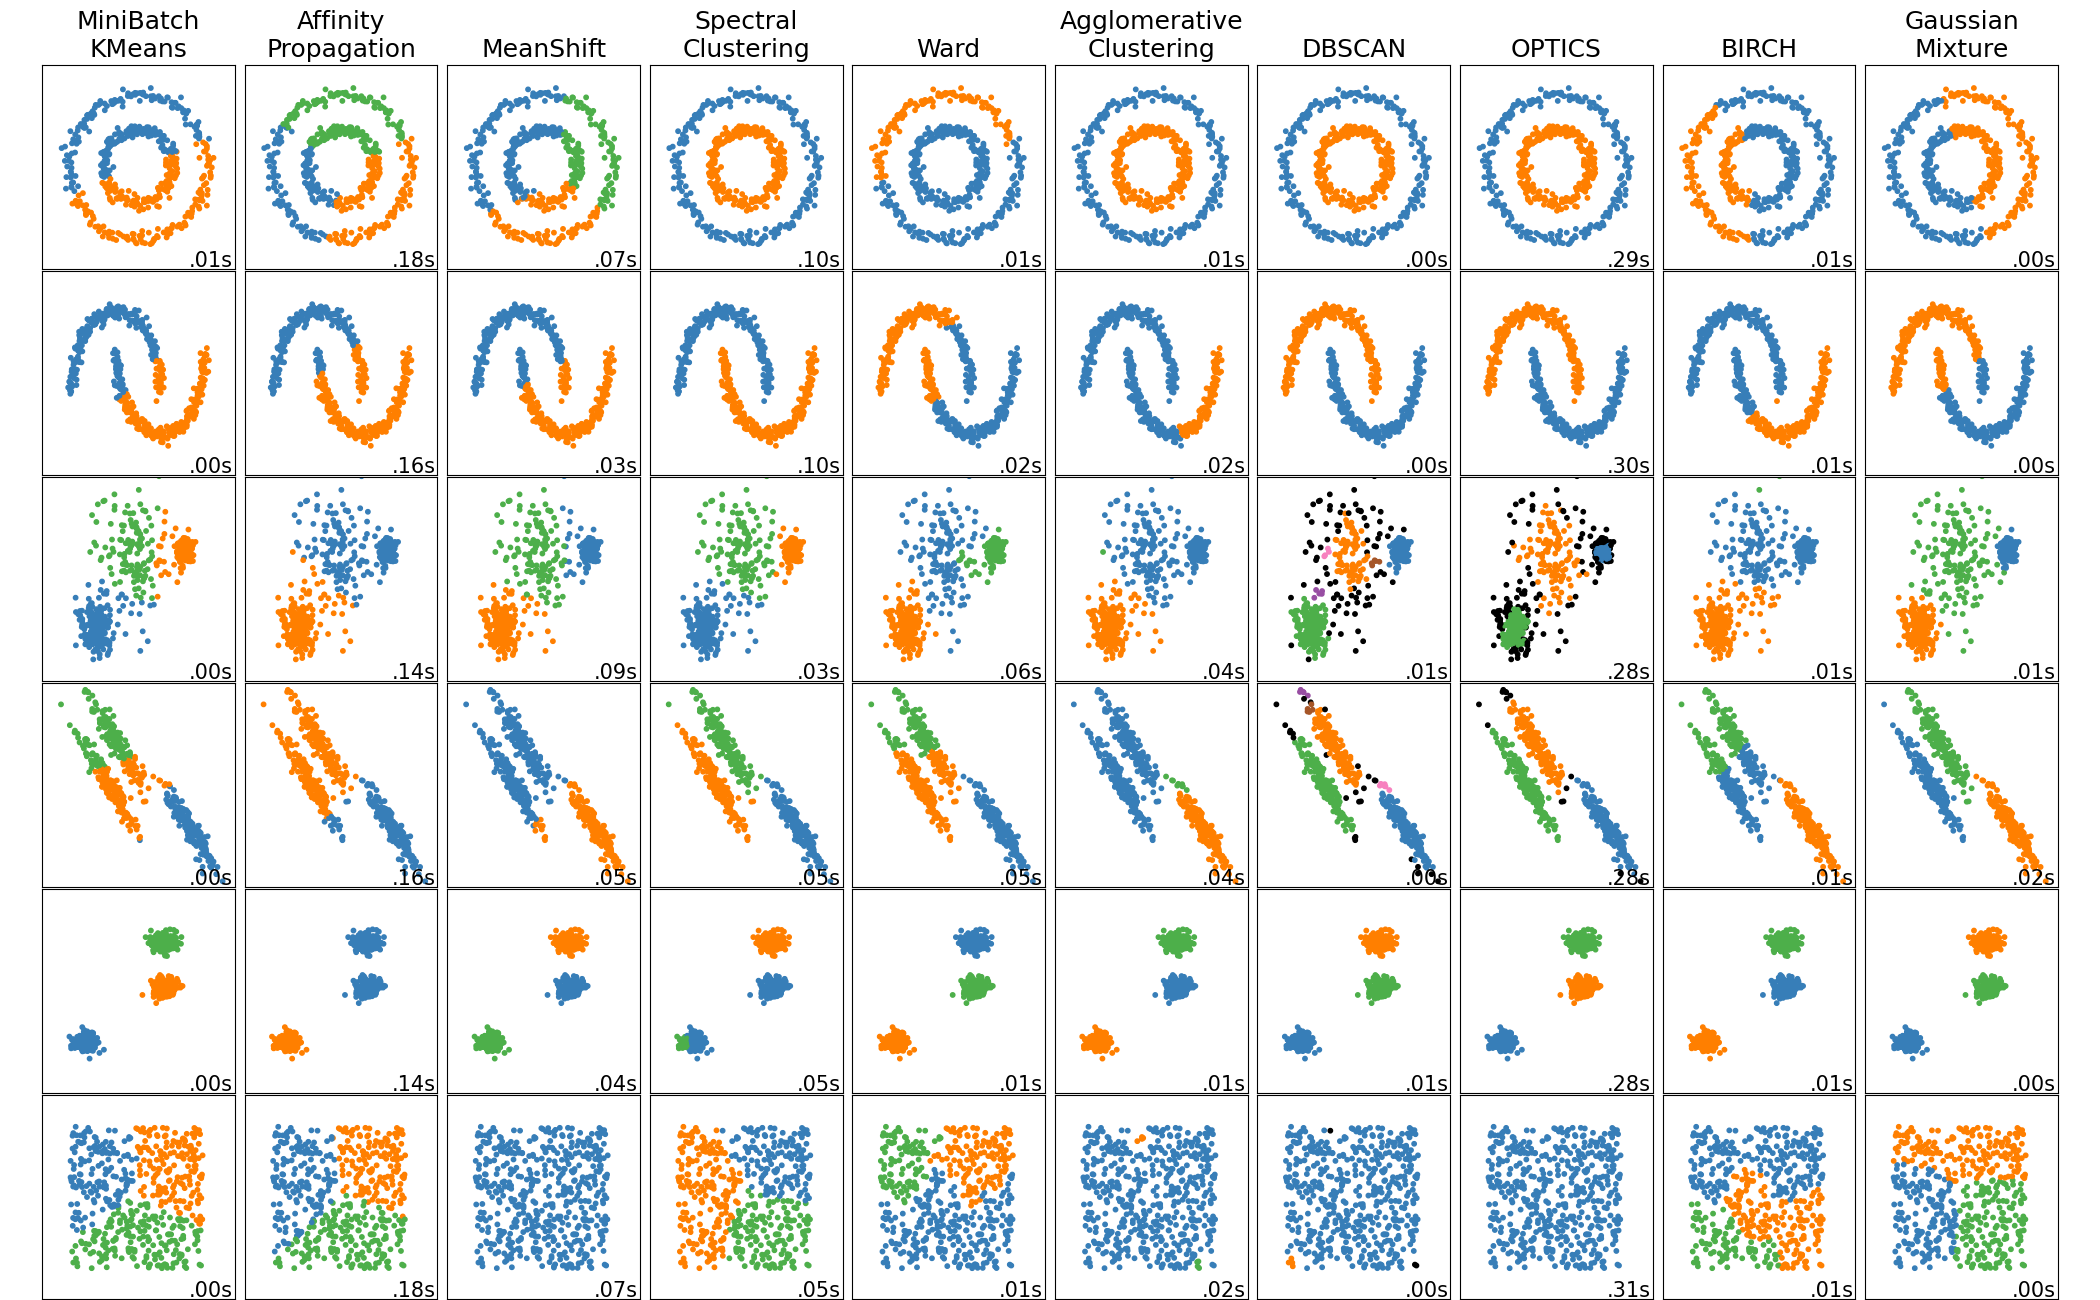

# Onderzoeken modellen

Na onderzoek te doen naar de gekozen modellen zijn de volgende problemen gevonden:

AffinityPropagation -- werkt niet op grote datasets \
SpectralClustering -- werkt niet met veel clusters \
AgglomerativeClustering -- geen mogelijkheid voor predict nieuwe data \
DBSCAN -- geen mogelijkheid voor predict nieuwe data \
OPTICS -- geen mogelijkheid voor predict nieuwe data

Dus blijven alleen KMeans, BIRCH en GausianMixture over

# Data Opstellen

De data die als input gebruikt moet worden kan 1 van 3 opties zijn:

- Meest invloedrijke features
- X aantal geselecteerde features
- Vergelijkbare uitkomst model

We gaan voor het testen uit van de meest invloedrijke features, die naar onderzoek van Wijnand de volgende zijn:

- Department
- Diagnose
- Marital status
- Race
- Herkomst
- Icd version

Dit is echter van een model waarbij geslacht wordt voorspeld, dus de features zijn aangepast tot:

- Department
- Marital status
- Race
- Herkomst
- Geslacht




In [17]:
dfClean = df.drop(columns=['Unnamed: 0', "patient_id", "geboortedatum", "opname_nummer", "zkh_opn_start", "icd_version", "start_operatie", "endtime", "duur_ok_minutes", "length_of_stay_days", "time_to_surgery_minutes"])
dfRaw = df.drop(columns=['Unnamed: 0'])

dfClean

,geslacht,herkomst,marital_status,race,diagnose,department,target
0,F,Other,WIDOWED,WHITE,07070,MED,0
1,F,Medicaid,WIDOWED,WHITE,07071,MED,0
2,F,Medicaid,WIDOWED,WHITE,07054,MED,0
3,F,Other,SINGLE,WHITE,30500,MED,0
4,F,Other,DIVORCED,WHITE,E7800,ORTHO,0
...,...,...,...,...,...,...,...
229416,F,Other,SINGLE,WHITE,B954,MED,1
229417,F,Other,SINGLE,WHITE,B9620,SURG,1
229418,M,Other,WIDOWED,WHITE,2724,MED,1
229419,M,Other,WIDOWED,WHITE,2724,NMED,1


Nadat deze data is opgeschoont, moet het worden ge-encode. Dit is vanwege het feit dat clustermodellen alleen maar numerieke waardes als input kunnen hebben.

Hierbij is gekozen voor OneHotEncoding, aangezien de waardes in zichzelf geen duidelijke relatie hebben met elkaar (LabelEncoding), en door het binair te maken kan een model makkelijker met deze waardes omgaan.

In [5]:
df_set = []

for column in dfClean.columns:
    df_set.append(pd.get_dummies(dfClean[column], prefix = column))
    print(f"encoded {column} : {len(dfClean[column].unique())}")

df_hot = pd.DataFrame()
for set in df_set:
    df_hot = pd.concat([df_hot, set], axis=1)
print("Made single set")


df_hot

encoded geslacht : 2
encoded herkomst : 3
encoded marital_status : 4
encoded race : 33
encoded diagnose : 6437
encoded department : 19
Made single set


,geslacht_F,geslacht_M,herkomst_Medicaid,herkomst_Medicare,herkomst_Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,race_AMERICAN INDIAN/ALASKA NATIVE,...,department_NSURG,department_OBS,department_OMED,department_ORTHO,department_PSURG,department_PSYCH,department_SURG,department_TRAUM,department_TSURG,department_VSURG
0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229416,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
229417,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
229418,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
229419,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Na het Encoden hebben we 61 features waarop het model wordt getraint

# Modellen testen

De volgende stap is om de modellen te testen, om zo te kijken welke beter is dan de andere en te kunnen bepalen welke wordt gekozen.

Hierbij kijken we naar 3 dingen:

- Tijd die het duurt om te trainen
- Aantal clusters
- Silhoette Coefficient 

De Sillhoette Coefficient is hierbij een manier om de clusters binnen een model te evalueren. Het is een score van -1 tot 1, waarbij -1 betekend dat alle clusters door elkaar zitten, 0 betekend dat de clusters compact zijn en minimaal door elkaar zitten en 1 betekend dat de clusters compact zijn en er afstand zit tussen de clusters.

We gebruiken hierbij de aantal clusters en de coefficient samen, om zo na te kunnen gaan wat de kwaliteit is van de cluster bij lagere aantal clusters.

Tot slot gaan we de data opsplitsen in een set van 25% en 75%, zodat in het geval dat een van de modellen langzaam traint, het geconstateerd kan worden bij de kleine set en niet gelijk een uur duurt om er achter te komen.

Bij elke keer trainen pakken we het eerste punt uit de andere set, en kijken we hoeveel de punten uit de hetzelfde cluster er gemiddeld op lijkt.

In [6]:
dfBig, dfSmall = train_test_split(df_hot)
dfBig

,geslacht_F,geslacht_M,herkomst_Medicaid,herkomst_Medicare,herkomst_Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,race_AMERICAN INDIAN/ALASKA NATIVE,...,department_NSURG,department_OBS,department_OMED,department_ORTHO,department_PSURG,department_PSYCH,department_SURG,department_TRAUM,department_TSURG,department_VSURG
130700,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30730,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
53701,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27999,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95929,1,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114262,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64711,0,1,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
113568,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73985,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
dfSmall

,geslacht_F,geslacht_M,herkomst_Medicaid,herkomst_Medicare,herkomst_Other,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,race_AMERICAN INDIAN/ALASKA NATIVE,...,department_NSURG,department_OBS,department_OMED,department_ORTHO,department_PSURG,department_PSYCH,department_SURG,department_TRAUM,department_TSURG,department_VSURG
198218,0,1,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
162087,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
137669,0,1,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
86744,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47397,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135666,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
144189,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
155359,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
86894,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


#### test K-modes voor de ongesplitste dataset

In [33]:
kmode = KModes(n_clusters=500, init='random', n_init=5, verbose=1)
kmode.fit_predict(dfClean[0:30000])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5075, cost: 34826.0
Run 1, iteration: 2/100, moves: 252, cost: 34821.0
Run 1, iteration: 3/100, moves: 1, cost: 34821.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 5012, cost: 34960.0
Run 2, iteration: 2/100, moves: 133, cost: 34960.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 4570, cost: 34896.0
Run 3, iteration: 2/100, moves: 411, cost: 34886.0
Run 3, iteration: 3/100, moves: 19, cost: 34885.0
Run 3, iteration: 4/100, moves: 1, cost: 34885.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 4209, cost: 35048.0
Run 4, iteration: 2/100, moves: 222, cost: 35031.0
Run 4, iteration: 3/100, moves: 2, cost: 35031.0
Init: initializing centroids
Init: initializing clusters
Starting itera

array([ 43,  26,  26, ...,  93, 107, 164], dtype=uint16)

In [34]:
#print(kmode.cluster_centroids_)
#print(kmode.labels_)
i = 0
l0 = []
l1 = []
l2 = []

for l in kmode.labels_:
    
    if l == 0:
        l0.append(i)
    elif l == 1:
        l1.append(i)
    elif l == 2:
        l2.append(i)
    
    i += 1
    
    
df_l0 = dfClean.loc[l0]

In [35]:
df_l0

,geslacht,herkomst,marital_status,race,diagnose,department
52,F,Medicare,SINGLE,WHITE,C50912,MED
53,F,Medicare,SINGLE,WHITE,C50912,SURG
54,F,Medicare,SINGLE,WHITE,C50912,MED
56,F,Medicare,SINGLE,WHITE,C3490,NSURG
193,F,Medicare,SINGLE,WHITE,00845,SURG
...,...,...,...,...,...,...
29801,F,Medicare,SINGLE,WHITE,42731,MED
29833,F,Medicare,SINGLE,WHITE,27801,SURG
29890,F,Medicare,SINGLE,WHITE,A419,MED
29891,F,Medicare,SINGLE,WHITE,A419,SURG


#### test nu op data die gesplitst is op diagnose

#### splits dataset op diagnose

In [19]:
dfs_by_diagnose = {
    diagnose: sub_df
    for diagnose, sub_df in dfClean.groupby("diagnose")
}

    
#print(dfs_by_diagnose)

In [23]:
for dia, df in dfs_by_diagnose.items():
    print(dia + ' ' + str(len(df)))

0020 2
0030 12
0031 4
00329 3
0038 2
0039 8
0040 1
0041 1
0048 1
0049 3
00581 1
00589 2
0059 10
0069 2
0071 6
0074 10
0078 1
00800 4
00809 2
00841 2
00843 12
00845 2216
00846 1
00847 2
00849 1
0085 12
00861 2
00862 4
00863 19
00867 3
00869 54
0088 391
0090 96
0091 38
0092 16
0093 2
01005 1
01083 1
01120 1
01123 3
01124 2
01164 1
01180 2
01186 1
01190 31
01191 1
01193 1
01194 2
01195 4
01196 4
01200 1
01202 2
01203 1
01205 1
01300 2
01325 2
01326 1
01354 1
01400 3
01402 2
01405 1
01500 2
01502 1
01505 1
01600 1
01720 5
01722 1
01724 1
01730 1
01792 1
01803 1
01804 1
01890 3
01893 1
01894 1
01895 1
01896 2
0218 1
0239 3
0270 15
0272 10
0309 1
0310 38
0311 4
0312 25
0318 13
0319 13
03285 5
03289 6
0329 28
0339 2
0340 51
035 17
0360 3
0361 1
0380 520
03810 22
03811 409
03812 249
03819 114
0382 81
0383 52
03840 66
03841 7
03842 612
03843 121
03844 32
03849 393
0388 114
0389 3256
0390 3
0391 7
0392 1
0393 1
0398 7
0400 26
04082 7
04089 1
04100 49
04101 92
04102 457
04103 16
04104 1472
04105 

40491 1
40493 1
40501 1
40591 3
40599 2
41001 5
41002 1
41011 15
41012 2
41021 2
41031 3
41041 13
41051 1
41052 1
41071 63
41072 6
41081 2
41082 1
41091 4
41092 3
4111 39
41181 1
41189 2
412 96
4131 8
4139 29
41400 120
41401 120
41402 1
41405 2
41410 3
4148 6
4149 1
41511 11
41519 12
4160 6
4161 1
4162 2
4168 32
4178 1
42090 4
42091 7
42099 1
4210 2
42290 1
42291 2
42292 1
4230 1
4231 1
4232 2
4233 1
4238 3
4239 31
4240 97
4241 33
4242 1
4251 5
42518 3
4253 1
4254 74
4255 1
4259 2
4260 16
42610 3
42611 4
42612 2
42613 3
4262 1
4263 4
4264 11
42653 1
4266 1
4267 12
42682 1
42689 1
4270 15
4271 28
42731 269
42732 13
42741 1
4275 11
42760 1
42761 1
42769 7
42781 12
42789 103
4279 2
4280 16
4289 1
4293 1
42983 3
42989 2
4299 1
430 39
431 7
4320 1
4321 3
4329 1
43301 1
43310 24
43320 1
43330 2
43411 5
43491 4
4358 1
4359 6
4371 1
4373 83
4375 3
4377 1
4380 1
43811 4
43820 1
43821 1
4387 1
43884 1
43889 3
4400 6
4401 6
44020 4
44021 62
44022 12
44023 16
44024 7
44030 2
44031 8
44032 1
4408 3

88023 1
88100 5
88101 3
88102 1
88110 8
88111 2
88120 7
88122 2
8820 8
8821 5
8822 12
8830 7
8831 5
8832 11
8850 3
8860 17
8900 3
8902 1
8910 11
8911 6
8912 2
8920 2
8921 7
8922 4
8950 1
9029 1
9033 1
9034 1
9040 1
9041 1
9052 1
9054 3
9092 1
9100 4
9101 1
9106 1
9115 1
9130 1
9131 1
9160 1
9190 1
9199 1
920 2
9212 1
9220 1
9221 4
9224 3
92300 1
92320 1
92400 2
92411 1
9248 4
92710 2
9273 1
9330 3
9351 7
9352 1
936 2
937 2
9390 1
94120 1
94213 1
94403 1
94420 1
94431 1
94522 1
9517 1
95205 1
9552 1
9556 1
9587 1
95892 5
95901 12
95909 1
95912 2
95913 1
95914 1
9593 1
9595 1
9620 1
9630 1
96509 1
9654 1
96561 2
9671 1
9678 2
9690 4
9694 1
9698 1
9712 1
9879 1
9895 2
9911 1
9951 4
9953 18
99561 2
99563 1
99564 1
99581 2
99585 1
99601 3
99604 1
9961 6
99632 1
99639 1
99642 5
99647 1
99649 7
99652 4
99654 2
99659 4
99667 2
99669 3
99674 4
99676 1
99678 6
99679 4
99709 3
9974 10
99741 2
99749 2
9975 1
99779 1
99811 28
99812 18
99813 13
9982 2
99830 1
99832 2
99851 2
99859 10
9986 2
99881 1


F78 1
F79 5
F840 4
F845 2
F88 3
F901 2
F909 23
F919 1
F99 1
G009 1
G030 3
G031 1
G038 1
G039 2
G041 1
G0489 1
G08 1
G10 1
G1221 4
G14 2
G20 39
G241 2
G244 2
G250 8
G252 1
G2581 16
G309 1
G3184 9
G35 44
G360 3
G371 1
G372 1
G373 3
G379 4
G40201 1
G40209 5
G40211 1
G40219 3
G40311 1
G40319 1
G40401 2
G40409 5
G40419 1
G40802 2
G4089 5
G40901 2
G40909 57
G40919 3
G40A09 1
G40B09 2
G43009 1
G43109 12
G43409 1
G43709 1
G43809 3
G43819 1
G43909 100
G43919 1
G43B0 1
G43D0 1
G44209 2
G44309 1
G4440 2
G4453 1
G4489 3
G453 3
G454 2
G458 2
G459 1
G460 3
G4700 40
G4709 1
G4730 8
G4731 1
G4733 180
G47419 4
G479 1
G500 7
G510 4
G540 8
G546 1
G548 1
G549 1
G5600 1
G5601 3
G5602 2
G5603 1
G5620 1
G5621 1
G5631 1
G5711 1
G5721 2
G5722 1
G5771 1
G5792 1
G588 4
G600 2
G608 1
G609 1
G610 17
G6181 3
G620 1
G6289 5
G629 29
G650 1
G7000 6
G7001 5
G7111 1
G712 1
G7289 1
G729 1
G800 1
G803 1
G809 3
G8101 2
G8104 1
G8114 1
G8191 16
G8194 21
G8220 5
G8222 2
G8250 4
G8251 1
G8252 1
G8314 1
G8321 5
G8324 3
G8331 1

S72352A 2
S72401A 1
S76112A 1
S81011A 1
S81021A 1
S81812A 1
S82102B 1
S82141A 8
S82142A 18
S82142B 1
S82145A 1
S82192B 1
S82201A 2
S82201K 2
S82201N 1
S82202A 5
S82222B 1
S82231A 2
S82241A 2
S82251A 1
S82251C 1
S82252A 1
S82252B 2
S82252C 1
S82291A 2
S82291B 2
S82301A 4
S82301K 1
S82302A 4
S82302B 1
S82391A 5
S82392A 5
S82392B 2
S82402A 1
S82432A 1
S82452A 1
S82492B 1
S8251XA 3
S8251XC 1
S8252XA 4
S8252XC 1
S8261XA 3
S8262XA 1
S82831A 3
S82831B 2
S82832A 1
S82841A 7
S82841B 1
S82842A 4
S82842B 1
S82842C 1
S82851A 12
S82851B 1
S82852A 9
S82871A 5
S82871D 2
S82871K 1
S82872A 4
S82872B 4
S82872K 1
S82891A 1
S82892K 1
S86391A 1
S89191A 1
S91011A 1
S91322A 1
S91341A 2
S92001A 1
S92022A 1
S92061A 1
S92311A 1
S92421B 1
T185XXA 2
T23712A 1
T704XXA 1
T796XXA 1
T79A22A 2
T8131XA 3
T8132XA 1
T814XXA 1
T8189XA 1
T84021A 1
T84033A 1
T84090A 1
T84124A 1
T84191A 1
T84228A 1
T8453XA 1
T84623A 1
T8484XA 1
T8544XA 1
T8549XA 1
T85590A 1
T85618A 1
T8579XA 4
V0481 1
V053 1
V08 1
V1005 1
V1006 12
V103 22
V1

#### test K-modes voor een diagnose

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2637, cost: 11540.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1070, cost: 11793.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 845, cost: 11437.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 930, cost: 11693.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1389, cost: 11870.0
Run 5, iteration: 2/100, moves: 468, cost: 11870.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 960, cost: 11874.0
Run 6, iteration: 2/100, moves: 57, cost: 11874.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves

Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 881, cost: 9344.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1020, cost: 9843.0
Run 3, iteration: 2/100, moves: 746, cost: 9613.0
Run 3, iteration: 3/100, moves: 24, cost: 9613.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1670, cost: 9772.0
Run 4, iteration: 2/100, moves: 143, cost: 9757.0
Run 4, iteration: 3/100, moves: 27, cost: 9757.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2034, cost: 9375.0
Run 5, iteration: 2/100, moves: 76, cost: 9376.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 1380, cost: 10367.0
Run 6, iteration: 2/100, moves: 203, cost: 10367.0
Init: initializing centroids
Init: initializing clusters
Starting iterations

Run 6, iteration: 2/100, moves: 536, cost: 8635.0
Run 6, iteration: 3/100, moves: 92, cost: 8635.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 1395, cost: 8586.0
Run 7, iteration: 2/100, moves: 34, cost: 8586.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1230, cost: 8488.0
Run 1, iteration: 2/100, moves: 191, cost: 8488.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1144, cost: 8507.0
Run 2, iteration: 2/100, moves: 16, cost: 8507.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2073, cost: 8618.0
Run 3, iteration: 2/100, moves: 5, cost: 8618.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1248, cost: 8289.0
Init: initializing centroids

Run 3, iteration: 2/100, moves: 91, cost: 7967.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1060, cost: 7453.0
Run 4, iteration: 2/100, moves: 18, cost: 7453.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1936, cost: 7737.0
Run 5, iteration: 2/100, moves: 2, cost: 7737.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 1139, cost: 7844.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 1052, cost: 7652.0
Run 7, iteration: 2/100, moves: 11, cost: 7652.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 709, cost: 7572.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 377, cost: 7470.0

Run 4, iteration: 2/100, moves: 81, cost: 6902.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 771, cost: 6947.0
Run 5, iteration: 2/100, moves: 60, cost: 6947.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 1167, cost: 6496.0
Run 6, iteration: 2/100, moves: 113, cost: 6496.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 1469, cost: 6793.0
Run 7, iteration: 2/100, moves: 84, cost: 6773.0
Run 7, iteration: 3/100, moves: 14, cost: 6773.0
Best run was number 6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1312, cost: 6724.0
Run 1, iteration: 2/100, moves: 154, cost: 6724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 856, cost: 6402.0
Init: initializing centroids


Run 6, iteration: 2/100, moves: 15, cost: 6957.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 990, cost: 6697.0
Run 7, iteration: 2/100, moves: 254, cost: 6663.0
Run 7, iteration: 3/100, moves: 19, cost: 6663.0
Best run was number 3
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1509, cost: 6292.0
Run 1, iteration: 2/100, moves: 144, cost: 6292.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1144, cost: 6564.0
Run 2, iteration: 2/100, moves: 100, cost: 6563.0
Run 2, iteration: 3/100, moves: 0, cost: 6563.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1336, cost: 6326.0
Run 3, iteration: 2/100, moves: 126, cost: 6326.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, move

Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 873, cost: 6061.0
Run 7, iteration: 2/100, moves: 215, cost: 6037.0
Run 7, iteration: 3/100, moves: 19, cost: 6037.0
Best run was number 5
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 786, cost: 5677.0
Run 1, iteration: 2/100, moves: 163, cost: 5677.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 472, cost: 6138.0
Run 2, iteration: 2/100, moves: 34, cost: 6138.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 693, cost: 5902.0
Run 3, iteration: 2/100, moves: 9, cost: 5902.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 895, cost: 6251.0
Run 4, iteration: 2/100, moves: 20, cost: 6247.0
Run 4, iteration: 3/100, moves: 0, cost: 6247.0
Init: initiali

Run 7, iteration: 1/100, moves: 1283, cost: 5487.0
Run 7, iteration: 2/100, moves: 196, cost: 5487.0
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1234, cost: 5473.0
Run 1, iteration: 2/100, moves: 8, cost: 5473.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1178, cost: 5205.0
Run 2, iteration: 2/100, moves: 18, cost: 5205.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1220, cost: 5529.0
Run 3, iteration: 2/100, moves: 82, cost: 5529.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1191, cost: 5875.0
Run 4, iteration: 2/100, moves: 135, cost: 5875.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 979, cost: 5581.0
Run 5, iteration: 2/100, mo

Run 6, iteration: 2/100, moves: 20, cost: 5016.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 749, cost: 5082.0
Run 7, iteration: 2/100, moves: 173, cost: 5080.0
Run 7, iteration: 3/100, moves: 56, cost: 5078.0
Run 7, iteration: 4/100, moves: 1, cost: 5078.0
Best run was number 6
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1138, cost: 5491.0
Run 1, iteration: 2/100, moves: 99, cost: 5491.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 910, cost: 5295.0
Run 2, iteration: 2/100, moves: 54, cost: 5295.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 744, cost: 5260.0
Run 3, iteration: 2/100, moves: 30, cost: 5260.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 64

Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 1402, cost: 4898.0
Run 6, iteration: 2/100, moves: 113, cost: 4896.0
Run 6, iteration: 3/100, moves: 0, cost: 4896.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 1067, cost: 5218.0
Run 7, iteration: 2/100, moves: 87, cost: 5207.0
Run 7, iteration: 3/100, moves: 9, cost: 5207.0
Best run was number 2


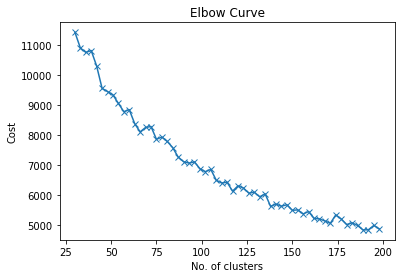

In [27]:
# Elbow curve to find optimal K
cost = []
K = range(30, 200, 3)
for k in list(K):
    kmode = KModes(n_clusters=k, init = 'Huang', n_init = 7, verbose=1)
    kmode.fit_predict(dfs_by_diagnose['25000'])
    cost.append(kmode.cost_)
      
plt.plot(K, cost, 'x-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
plt.show()

In [28]:
kmode = KModes(n_clusters=175, init = 'Huang', n_init = 15, verbose=1)
kmode.fit_predict(dfs_by_diagnose['25000'])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 643, cost: 5331.0
Run 1, iteration: 2/100, moves: 51, cost: 5331.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 1067, cost: 5180.0
Run 2, iteration: 2/100, moves: 173, cost: 5177.0
Run 2, iteration: 3/100, moves: 0, cost: 5177.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 977, cost: 5389.0
Run 3, iteration: 2/100, moves: 55, cost: 5389.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1091, cost: 5199.0
Run 4, iteration: 2/100, moves: 311, cost: 5193.0
Run 4, iteration: 3/100, moves: 41, cost: 5191.0
Run 4, iteration: 4/100, moves: 30, cost: 5185.0
Run 4, iteration: 5/100, moves: 10, cost: 5185.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5

array([ 27,  40,  38, ..., 106, 106, 172], dtype=uint16)

In [37]:
dfs_by_diagnose['25000']['cluster'] = [l for l in kmode.labels_]

In [38]:
dfs_by_diagnose['25000'][(dfs_by_diagnose['25000']['cluster'] == 1)]

,geslacht,herkomst,marital_status,race,diagnose,department,cluster
1617,F,Medicare,SINGLE,WHITE,25000,VSURG,1
2880,F,Medicare,SINGLE,HISPANIC OR LATINO,25000,NMED,1
3663,F,Medicare,SINGLE,WHITE,25000,CSURG,1
7777,F,Medicare,SINGLE,WHITE,25000,VSURG,1
10215,F,Medicare,SINGLE,WHITE,25000,NMED,1
...,...,...,...,...,...,...,...
222902,F,Medicare,SINGLE,WHITE,25000,VSURG,1
223841,F,Medicare,SINGLE,WHITE,25000,VSURG,1
223847,F,Medicare,SINGLE,WHITE,25000,VSURG,1
225691,F,Medicare,WIDOWED,WHITE,25000,CSURG,1


In [39]:
dfs_by_diagnose['25000'][(dfs_by_diagnose['25000']['cluster'] == 2)]

,geslacht,herkomst,marital_status,race,diagnose,department,cluster
522,M,Medicare,SINGLE,OTHER,25000,MED,2
1212,M,Medicare,SINGLE,BLACK/CAPE VERDEAN,25000,MED,2
1303,M,Medicaid,SINGLE,WHITE - OTHER EUROPEAN,25000,MED,2
3199,M,Medicaid,SINGLE,UNKNOWN,25000,MED,2
4968,M,Medicaid,SINGLE,BLACK/CAPE VERDEAN,25000,MED,2
...,...,...,...,...,...,...,...
209064,M,Medicare,SINGLE,HISPANIC/LATINO - PUERTO RICAN,25000,MED,2
209065,M,Medicare,SINGLE,HISPANIC/LATINO - PUERTO RICAN,25000,MED,2
218980,M,Medicare,SINGLE,HISPANIC/LATINO - PUERTO RICAN,25000,MED,2
218981,M,Medicare,SINGLE,HISPANIC/LATINO - PUERTO RICAN,25000,MED,2


In [40]:
dfs_by_diagnose['25000'][(dfs_by_diagnose['25000']['cluster'] == 3)]

,geslacht,herkomst,marital_status,race,diagnose,department,cluster
6364,F,Medicaid,WIDOWED,BLACK/AFRICAN AMERICAN,25000,ORTHO,3
6366,F,Medicaid,WIDOWED,OTHER,25000,ORTHO,3
6367,F,Medicaid,MARRIED,BLACK/AFRICAN AMERICAN,25000,MED,3
12708,M,Medicaid,MARRIED,BLACK/AFRICAN AMERICAN,25000,ORTHO,3
12709,M,Medicaid,MARRIED,BLACK/AFRICAN AMERICAN,25000,ORTHO,3
...,...,...,...,...,...,...,...
216748,F,Medicaid,MARRIED,ASIAN - CHINESE,25000,ORTHO,3
217863,F,Medicaid,WIDOWED,BLACK/AFRICAN AMERICAN,25000,SURG,3
219718,F,Medicaid,MARRIED,BLACK/AFRICAN AMERICAN,25000,SURG,3
221569,F,Medicaid,MARRIED,BLACK/AFRICAN AMERICAN,25000,MED,3


In [41]:
dfs_by_diagnose['25000'][(dfs_by_diagnose['25000']['cluster'] == 4)]

,geslacht,herkomst,marital_status,race,diagnose,department,cluster
360,F,Medicare,WIDOWED,BLACK/AFRICAN AMERICAN,25000,ORTHO,4
1775,F,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,25000,MED,4
2201,F,Medicare,WIDOWED,BLACK/AFRICAN AMERICAN,25000,MED,4
3047,F,Medicare,MARRIED,BLACK/AFRICAN AMERICAN,25000,MED,4
3905,F,Medicare,WIDOWED,BLACK/AFRICAN AMERICAN,25000,ORTHO,4
...,...,...,...,...,...,...,...
226980,F,Medicare,WIDOWED,BLACK/AFRICAN AMERICAN,25000,MED,4
227164,F,Medicare,MARRIED,BLACK/AFRICAN AMERICAN,25000,MED,4
227185,F,Medicare,WIDOWED,BLACK/AFRICAN AMERICAN,25000,VSURG,4
227322,F,Medicare,MARRIED,BLACK/AFRICAN AMERICAN,25000,MED,4


In [42]:
dfs_by_diagnose['25000'][(dfs_by_diagnose['25000']['cluster'] == 5)]

,geslacht,herkomst,marital_status,race,diagnose,department,cluster
1884,M,Other,WIDOWED,WHITE,25000,ORTHO,5
2473,M,Other,WIDOWED,WHITE,25000,ORTHO,5
8290,M,Other,WIDOWED,WHITE,25000,ORTHO,5
8808,F,Other,WIDOWED,WHITE,25000,ORTHO,5
10822,M,Other,WIDOWED,ASIAN,25000,TRAUM,5
...,...,...,...,...,...,...,...
212678,M,Other,WIDOWED,WHITE,25000,VSURG,5
212680,M,Other,WIDOWED,WHITE,25000,VSURG,5
214754,F,Other,WIDOWED,WHITE,25000,ORTHO,5
223963,F,Other,WIDOWED,WHITE - RUSSIAN,25000,ORTHO,5


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 42, cost: 312.0
Run 1, iteration: 2/100, moves: 5, cost: 312.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 27, cost: 301.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 23, cost: 272.0
Run 3, iteration: 2/100, moves: 0, cost: 272.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 28, cost: 307.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 37, cost: 303.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 22, cost: 295.0
Run 6, iteration: 2/100, moves: 6, cost: 295.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iter

Starting iterations...
Run 1, iteration: 1/100, moves: 18, cost: 97.0
Run 1, iteration: 2/100, moves: 2, cost: 97.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6, cost: 103.0
Run 2, iteration: 2/100, moves: 0, cost: 103.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 4, cost: 104.0
Run 3, iteration: 2/100, moves: 1, cost: 104.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6, cost: 89.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 15, cost: 106.0
Run 5, iteration: 2/100, moves: 0, cost: 106.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 13, cost: 93.0
Run 6, iteration: 2/100, moves: 8, cost: 87.0
Run 6, iteration: 3/100, moves: 1, cost: 86.0
Run 6, iteration

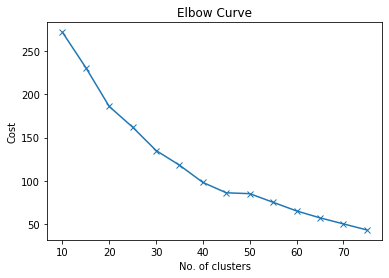

In [33]:
# Elbow curve to find optimal K
cost = []
K = range(10, 80, 5)
for k in list(K):
    kmode = KModes(n_clusters=k, init = 'Huang', n_init = 7, verbose=1)
    kmode.fit_predict(dfs_by_diagnose['1579'].drop(columns=['target']))
    cost.append(kmode.cost_)
      
plt.plot(K, cost, 'x-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
plt.show()

In [34]:
kmode = KModes(n_clusters=45, init = 'Huang', n_init = 15, verbose=1)
kmode.fit_predict(dfs_by_diagnose['1579'].drop(columns=['target']))
dfs_by_diagnose['1579']['cluster'] = [l for l in kmode.labels_]
#dfs_by_diagnose['1579']

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 7, cost: 104.0
Run 1, iteration: 2/100, moves: 0, cost: 104.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 16, cost: 107.0
Run 2, iteration: 2/100, moves: 0, cost: 107.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 7, cost: 100.0
Run 3, iteration: 2/100, moves: 0, cost: 100.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10, cost: 107.0
Run 4, iteration: 2/100, moves: 2, cost: 107.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 2, cost: 101.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 5, cost: 98.0
Init: initializing centroids
Init: initializing c

In [35]:
dfs_by_diagnose['1579'][(dfs_by_diagnose['1579']['cluster'] == 1)]

,geslacht,herkomst,marital_status,race,diagnose,department,target,cluster
4344,F,Other,SINGLE,HISPANIC/LATINO - HONDURAN,1579,SURG,1,1
17465,F,Other,SINGLE,WHITE,1579,MED,0,1
19056,F,Other,SINGLE,WHITE,1579,SURG,1,1
33520,F,Other,SINGLE,WHITE,1579,MED,0,1
117341,F,Other,SINGLE,WHITE,1579,MED,1,1
136444,F,Other,DIVORCED,WHITE,1579,MED,0,1
151083,F,Other,DIVORCED,WHITE,1579,MED,0,1
188737,F,Other,SINGLE,ASIAN - SOUTH EAST ASIAN,1579,MED,1,1
199619,F,Other,SINGLE,BLACK/AFRICAN AMERICAN,1579,MED,0,1


In [36]:
dfs_by_diagnose['1579'][(dfs_by_diagnose['1579']['cluster'] == 2)]

,geslacht,herkomst,marital_status,race,diagnose,department,target,cluster
28437,M,Medicare,DIVORCED,WHITE,1579,MED,0,2
51646,M,Medicare,WIDOWED,WHITE,1579,MED,0,2
52651,M,Medicare,WIDOWED,WHITE,1579,MED,0,2
52652,M,Medicare,WIDOWED,WHITE,1579,MED,0,2
121805,M,Medicare,WIDOWED,WHITE,1579,MED,1,2


In [32]:
dfs_by_diagnose['1579'][(dfs_by_diagnose['1579']['cluster'] == 4)]

,geslacht,herkomst,marital_status,race,diagnose,department,target,cluster
62105,F,Other,WIDOWED,WHITE,1579,SURG,1,4
71772,F,Other,MARRIED,WHITE,1579,SURG,0,4
90078,F,Other,MARRIED,HISPANIC/LATINO - PUERTO RICAN,1579,SURG,0,4
104650,F,Other,WIDOWED,WHITE,1579,SURG,1,4
161181,F,Other,MARRIED,WHITE,1579,SURG,0,4
186241,F,Other,MARRIED,WHITE,1579,SURG,0,4


Nu dat de data is opgesplitst, gaan we de modellen trainen en vergelijken.

We beginnen eerst met de kleine dataset met 500 en 1000 clusters, aangedien dit een gemiddelde van 100 en 50 items per cluster geeft.

In [7]:
print("KMeans 500 clusters")
KM = cl.KMeans(n_clusters = 500)
start = time.time()
KM.fit(dfSmall)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfSmall, KM.labels_)}")
print()

dfCheck = dfClean.iloc[dfSmall.index].copy()
dfCheck["label"] = KM.labels_
dfCheck = dfCheck[dfCheck['label']== KM.predict(dfBig.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfBig.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())


KMeans 500 clusters
Time: 28.865640878677368
Score: 0.7407718972473345

count    848.000000
mean       0.971934
std        0.069507
min        0.800000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: simular, dtype: float64


In [8]:
print("KMeans 1000 clusters")
KM = cl.KMeans(n_clusters = 1000)
start = time.time()
KM.fit(dfSmall)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfSmall, KM.labels_)}")
print()

dfCheck = dfClean.iloc[dfSmall.index].copy()
dfCheck["label"] = KM.labels_
dfCheck = dfCheck[dfCheck['label']== KM.predict(dfBig.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfBig.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())

KMeans 1000 clusters
Time: 98.62083292007446
Score: 0.8564213187231037

count    780.000000
mean       0.986923
std        0.049472
min        0.800000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: simular, dtype: float64


In [9]:
print("BIRCH 500 clusters")
BC = cl.Birch(n_clusters = 500)
start = time.time()
BC.fit(dfSmall)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfSmall, BC.labels_)}")
print()

dfCheck = dfClean.iloc[dfSmall.index].copy()
dfCheck["label"] = BC.labels_
dfCheck = dfCheck[dfCheck['label']== BC.predict(dfBig.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfBig.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())

BIRCH 500 clusters


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310:

Time: 26.329209804534912
Score: 0.7656501568445111

count    729.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: simular, dtype: float64


In [10]:
print("BIRCH 1000 clusters")
BC = cl.Birch(n_clusters = 1000)
start = time.time()
BC.fit(dfSmall)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfSmall, BC.labels_)}")
print()

dfCheck = dfClean.iloc[dfSmall.index].copy()
dfCheck["label"] = BC.labels_
dfCheck = dfCheck[dfCheck['label']== BC.predict(dfBig.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfBig.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())

BIRCH 1000 clusters


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310: RuntimeWarning: overflow encountered in ubyte_scalars
  new_ss = self.squared_sum_ + nominee_cluster.squared_sum_
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_birch.py:310:

Time: 18.88301396369934
Score: 0.8829741500819446

count    729.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: simular, dtype: float64


In [11]:
print("GaussianMixture 500 clusters")
GM =  mi.GaussianMixture(n_components = 500)
start = time.time()
GM.fit(dfSmall)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfSmall, GM.predict(dfSmall))}")
print()

dfCheck = dfClean.iloc[dfSmall.index].copy()
dfCheck["label"] = GM.predict(dfSmall)
dfCheck = dfCheck[dfCheck['label']== GM.predict(dfBig.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfBig.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())

GaussianMixture 500 clusters
Time: 442.93423199653625
Score: 0.7391307293655062

count    862.000000
mean       0.969142
std        0.072288
min        0.800000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: simular, dtype: float64


In [12]:
print("GaussianMixture 1000 clusters")
GM =  mi.GaussianMixture(n_components = 1000)
start = time.time()
GM.fit(dfSmall)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfSmall, GM.predict(dfSmall))}")
print()

dfCheck = dfClean.iloc[dfSmall.index].copy()
dfCheck["label"] = GM.predict(dfSmall)
dfCheck = dfCheck[dfCheck['label']== GM.predict(dfBig.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfBig.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())

GaussianMixture 1000 clusters
Time: 644.1706221103668
Score: 0.8541515262141723

count    764.000000
mean       0.990838
std        0.041843
min        0.800000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: simular, dtype: float64


Na 5 keer runnen gaan we alle gemiddelde uitkomsten op een rijtje zetten en vergelijken met elkaar.

|          | Clusters | Time    | Silhoette | Simulatity |
|----------|----------|---------|-----------|------------|
| KMeans   | 500      | 26 sec  | 0.73      | 0.96       |
|          | 1000     | 72 sec  | 0.85      | 0.97       |
| BIRCH    | 500      | 18 sec  | 0.75      | 0.99       |
|          | 1000     | 18 sec  | 0.87      | 0.98       |
| Gaussian | 500      | 252 sec | 0.73      | 0.96       |
|          | 1000     | 574 sec | 0.85      | 0.97       |

Zoals te zien is hebben alle modellen per hoeveelheid clusters vrijwel dezelfde silhoette score. Daarnaast is bij het vergelijken van random punten in dezelfde clusters de scores vrijwel hetzelfde.

Het enige wat echt overduidelijk verschilt hier is de tijd die het kost om het model te trainen. Hierbij zijn KMeans en BIRCH het snelst met tijden rond de 1 minuut of minder, en is Gaussian Mixture het traagst met minstends 4 minuten aan train tijd.

Dus voor dat we de volgende tests gaan uitvoeren met de modellen elimineren we Gaussian Mixture, vanwege het feit dat het zo lang duurt om het model te trainen in tegenstelling tot de andere modellen.

De volgende stap is om dezelfde tests zonder Gaussian Mixture uit te voeren op de grote dataset met 1000 en 2000 clusters, aangezien dit een gemiddelde van 150 en 80 items per cluster geeft.

In [13]:
print("KMeans 1000 clusters")
KM = cl.KMeans(n_clusters = 1000)
start = time.time()
KM.fit(dfBig)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfBig, KM.labels_)}")
print()

dfCheck = dfClean.iloc[dfBig.index].copy()
dfCheck["label"] = KM.labels_
dfCheck = dfCheck[dfCheck['label']== KM.predict(dfSmall.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfSmall.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())

KMeans 1000 clusters
Time: 294.33285188674927
Score: 0.8469393283863393

count    41.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: simular, dtype: float64


In [14]:
print("KMeans 2000 clusters")
KM = cl.KMeans(n_clusters = 2000)
start = time.time()
KM.fit(dfBig)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfBig, KM.labels_)}")
print()

dfCheck = dfClean.iloc[dfBig.index].copy()
dfCheck["label"] = KM.labels_
dfCheck = dfCheck[dfCheck['label']== KM.predict(dfSmall.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfSmall.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())

KMeans 2000 clusters


KeyboardInterrupt: 

In [ ]:
print("BIRCH 1000 clusters")
BC = cl.Birch(n_clusters = 1000)
start = time.time()
BC.fit(dfBig)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfBig, BC.labels_)}")
print()

dfCheck = dfClean.iloc[dfBig.index].copy()
dfCheck["label"] = BC.labels_
dfCheck = dfCheck[dfCheck['label']== BC.predict(dfSmall.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfSmall.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())

In [ ]:
print("BIRCH 2000 clusters")
BC = cl.Birch(n_clusters = 2000)
start = time.time()
BC.fit(dfBig)
stop = time.time()
print(f"Time: {stop-start}")
print(f"Score: {silhouette_score(dfBig, BC.labels_)}")
print()

dfCheck = dfClean.iloc[dfBig.index].copy()
dfCheck["label"] = BC.labels_
dfCheck = dfCheck[dfCheck['label']== BC.predict(dfSmall.head(1))[0]].drop(columns=['label'])
columns = dfCheck.columns

dfCheck["simular"] = 0

for column in columns:
    dfCheck.loc[dfCheck[column] == dfClean.iloc[dfSmall.head(1).index][column].item(), "simular"] +=1

dfCheck["simular"] = dfCheck["simular"]/len(columns)
print(dfCheck["simular"].describe())

Na 5 keer runnen gaan we alle gemiddelde uitkomsten op een rijtje zetten en vergelijken met elkaar.

|          | Clusters | Time    | Silhoette | Simulatity |
|----------|----------|---------|-----------|------------|
| KMeans   | 1000     | 4 min   | 0.85      | 0.00       |
|          | 2000     | 10 min  | 0.93      | 0.00       |
| BIRCH    | 1000     | 3 min   | 0.88      | 0.00       |
|          | 2000     | 3 min   | 0.95      | 0.00       |

Zoals bij de vorige testen is te zien dat alle modellen per hoeveelheid clusters vrijwel dezelfde silhoette score hebben.

Het enige wat echt weer overduidelijk verschilt hier is de tijd die het kost om het model te trainen. Hierbij is KMeans bij 2000 clusters veel trager dan bij 1000 clusters, en is BIRCH het snelst in beide gevallen.

Als we de twee rondes aan testen vergelijken zien we ook dat de train tijd bij KMeans schaalt met de hoeveelheid clusters en de hoeveelheid data, en bij BIRCH alleen maar schaalt met de hoeveelheid data.

We kunnen uit deze laatste test met vrijwel zekerheid zeggen dat BIRCH in ons geval beter is te gebruiken dan KMeans.

# Conclusie

Na het onderzoeken van de gekozen algoritmes op een grote en een kleine dataset blijkt dat BIRCH het beste algoritme is om bij ons te gebruiken om vergelijkbare patienten te clusteren.

# Feedback Danielle

- Aantal clusters checken met behulp van andere algoritmes bijvoorbeeld DBSCAN.
- Kijken naar hierarchisch clusteren. (Zie thesis Nicole van Gils)
- Met behulp van visualisatie clusters evalueren.
- Keuzes algoritmes en redenen van afvallen uitbreiden